# **DeePTB** V2.0 快速上手指南 | 训练 Silicon 的紧束缚模型

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2024 @ Authors</i></b><br/>
        作者: <a style="font-weight:normal" href="mailto:guqq@pku.edu.cn">顾强强 📨 </a>, <a href="mailto:zhouyinzhanghao@gmail.com">周寅张皓 📨 </a>, <a href="mailto:ganzixi@dp.tech">甘子熙 📨 </a></b></i><br/>
        日期：2024-04-09<br/>
        共享协议：本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i><br/>
        快速开始：点击上方的 <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">开始连接</span> 按钮，稍等片刻即可运行。
    </p>
</div>

<p style="color:purple; font-weight:bold">DeePTB 是一种采用深度学习加速第一性原理电子结构模拟的方法。该软件已迭代更新至 v2.1.0 版本。v2版本的 DeePTB 在v1 版本构建具有第一性原理精度的紧束缚（TB）模型的方法（DeePTB-SK）功能基础上，新添了 E3 等变网络表示单电子算符（包括哈密顿量、密度矩阵、交叠矩阵）（即 DeePTB-E3）的功能，从而实现多种方案来加速材料的电子结构模拟。</p> 

**本教程主要介绍DeePTB-SK模块构建TB模型的基本操作，涉及数据的准备、模型训练以及调用。**

完成本案例你将：
1. 熟悉 DeePTB 模型的训练流程
2. 得到高精度的硅晶体的完整 DeePTB 模型
3. 熟悉 DeePTB 性质计算模块的使用方式

## 目录

* [方法介绍](#method)
* [方法实践](#practice)
  * [1. 数据准备](#dataprepare)
  * [2. 训练模型](#train)
  * [3. 性质计算](#application)

## 方法介绍: <a id ='method'></a>
**DeePTB-SK** 模块是 DeePTB v1 版本实现的方法。该方法的基本思想是通过深度学习DFT电子能带，从而训练Slater-Koster (SK)参数[\[1\]](https://journals.aps.org/pr/abstract/10.1103/PhysRev.94.1498)构建紧束缚（Tight-Binding, TB）模型，从而快速实现第一性原理精度的电子结构和性质计算。 在 TB 模型中，哈密顿矩阵元可以表示为:
$
\begin{equation}
H_{i,j}^{lm,l^\prime m^\prime} =  \left\langle {i,lm} \right| \hat{H} \left| {j, l^\prime m^\prime} \right\rangle 
\end{equation}
$
其中 $i$, $j$ 是原子的 site 指标。$l$ 和 $m$ 是 site 对应原子的轨道角量子数与磁量子数（angular and magnetic quantum number）。**DeePTB** 的方法的目标就是通过学习DFT的电子能量本征值，利用神经网络预测给定结构的哈密顿量矩阵元。但是，由于哈密顿量本身具有规范变化自由度，因此电子能量本征值并不能完全决定哈密顿量。因此在 **DeePTB** 中选取了传统的SK参数化的哈密顿量，即：所有的哈密顿量跃迁矩阵元可以从规范无关的参数SK键积分 $h_{ss\sigma}, h_{sp\sigma}, h_{pp\sigma}, h_{pp\pi}, \cdots$ 等来表示。根据这些键积分，我们可以构建旋转变换到哈密顿量矩阵元，即:
$
\begin{equation}
	H_{i,j}^{lm,l^\prime m^\prime} = \sum_{\zeta} \Big[ \mathcal{U}_{\zeta}(\hat{r}_{ij}) \ h_{ll^\prime \zeta} \Big]_{mm^\prime}
\end{equation}
$
这里 $\mathcal{U}_{\zeta}$ 是一个 $[2l+1,2l^\prime+1]$ 的旋转矩阵，$\zeta$ 表示成键类型如：$\sigma, \pi$等。$\mathcal{U}_{\zeta}$的具体形式可以参考[\[1\]](https://journals.aps.org/pr/abstract/10.1103/PhysRev.94.1498).
传统的 SK-TB 中，SK 键积分往往采用了经验规则下的解析表达式，键积分基于双中心近似并只和两个原子的距离有关。 在 **DeePTB** 中，我们采用了一种基于神经网络的方法来预测 SK 键积分，即:
$
\begin{equation}
h^{\text{env}}_{ll^\prime{\zeta}} =  h_{ll^\prime{\zeta}}(r_{ij}) \times \left[1+\Phi_{ll^\prime\zeta}^{o_i,o_j}\left(r_{ij},\mathcal{D}^{ij}\right)\right]	
\end{equation}
$

其中 $h_{ll^\prime{\zeta}}$ 同样是基于解析表达式且只两个原子的距离有关的SK键积分，在DeePTB 中解析表达式的待定系数由trainable神经元表示。而 $h^{\text{env}}_{ll^\prime{\zeta}}$ 则是利用神经网络引入键局域环境修正后，局域环境依赖的键积分。 除了跃迁项外，紧束缚哈密顿量其他元素，如占位能，以及自选轨道耦合 SOC作用强度等参数也进行类似的参数化形式。在DeePTB的文章中，我们有对方法进行详细的解释和说明，搭配使用将会对读者有更好的理解。请参考 DeePTB paper: [Nat Commun 15, 6772 (2024)](https://arxiv.org/abs/2307.04638)。

DeePTB 方法的主要思路可以总结为如下图所示：

<img src="http://dp-filetrans.oss-accelerate.aliyuncs.com/DeePTB/model_arch.png?OSSAccessKeyId=LTAI5tRnCpedMnKSH3APDceY&Expires=1001689817421&Signature=BmHpXFjUAjkSaghC63rOtXme4Lo%3D" alt="Fig1" style="zoom: 40%;">

DeePTB的计算基本流程为：
1. 数据准备：
   - 结构数据
   - DFT电子能带数据
2. 模型训练：
   - 训练神经网络参数化的经验紧束缚 (nnsk) 模型.
   - 训练包含环境修正的深度学习紧束缚（mix）模型.
3. 模型测试：
   - 模型性能测试
   - 模型性质计算

**NOTE**： **DeePTB-SK** 模块中的训练 label 是 DFT 的电子能量本征值，因此没有要求本征值的来源，不仅仅是可以 LCAO 基组的 DFT 软件，也可以是基于平面波基组的 DFT 软件，也并不会要求必须是某一种泛函，甚至如果可以的话，可以是来自实验的能带数据。

## 方法实践 <a id ='practice'></a>

在常温常压下，Silicon 具有金刚石结构，其在半导体行业具有广泛应用，且具有重要意义。在这里，我们提供一个构建单晶硅的 **DeePTB** 模型的例子。按照这个步骤，您将了解到 **DeePTB** 的大部分功能，训练完成后，可以得到一个拥有第一性原理精度的深度学习TB模型。

首先我们定位到silicon样例的目录

In [1]:
import os
os.chdir("/root/DeePTB/examples/silicon")

### **1. 数据准备** <a id ='dataprepare'></a>


用以训练模型，和画图验证的数据放在 `data` 文件夹里：

```bash
deeptb/examples/silicon/data/
|-- kpath.0                 # train data of primary cell. (k-path bands)
|-- kpathmd25.0             # train data of 10 MD snapshots at T=25K   (k-path bands)
|-- kpathmd100.0            # train data of 10 MD snapshots at T=100K  (k-path bands)
|-- kpathmd300.0            # train data of 10 MD snapshots at T=300K  (k-path bands)
|-- kpt.0                   # kmesh samples of primary cell  (k-mesh bands)
|-- kpath_spk.0
|-- silicon.vasp            # structure of primary cell
```

该文件夹下数据集的含义如下：
- `kpath.0`：单胞的能带数据
- `kpathmd25.0`：25K下的10个MD快照的能带数据
- `kpathmd100.0`：100K下的10个MD快照的能带数据
- `kpathmd300.0`：300K下的10个MD快照的能带数据
- `kpt.0`：单胞的k点网格采样数据
- `silicon.vasp`: 单胞的结构数据

每个数据集都包含了 **DeePTB** 的数据文件，例如`kpath.0`：
```bash
deeptb/examples/silicon/data/kpath.0/
-- info.json # defining the training objective and edge cutoff of atomic data
-- eigenvalues.npy # numpy array of shape [num_frame, num_kpoint, num_band]
-- kpoints.npy # numpy array of shape [num_kpoint, 3]
-- xdat.traj # ase trajectory file with num_frame
```
其中：
- `info.json`：此文件的文件名是固定的，提供 DeePTB 模型中加载的数据集的信息。内容包括：轨迹的快照数量`nframes`、每个快照的原子数`natoms`、构建分子图的选项`AtomicData_options`和能带的加载信息`bandinfo`等关键词。内容格式如下:
```json
{
    "nframes": 1,
    "pos_type": "ase",
    "AtomicData_options": {
        "r_max": 2.6,
        "er_max": 4.1,
        "oer_max": 2.5,
        "pbc": true
    },
    "bandinfo": {
        "band_min": 0,
        "band_max": 8,
        "emin": null,
        "emax": null
    }
}
```
> 
> `AtomicData_options`是构建晶体图数据集的重要参数，包括了建立晶体图时采用的键长截断半径`r_max`、建立键环境的截断半径`er_max`和建立位点环境时的截断半径`oer_max`，以及是否在建立晶体图时考虑周期边界条件（PBC）。`AtomicData_options`对于数据如何加载到模型中是至关重要的。
> 
> `bandinfo`标记了能带文件中的k点数`nkpoints`和能带数`nbands`，还标记了能带窗口信息。能带窗口信息可以按照能带指标排序，也可以按照能量大小划分。


- `eigenvalues.npy`：此文件的文件名固定，为能带原始数据，shape为`[n_frames, nkpoints, nbands]`
- `kpoints.npy`：此文件的文件名固定，为k点原始数据，shape为`[nkpoints, 3]`
- `xdat.traj`: 此文件可以任意前缀，而固定用".traj"后缀，为轨迹结构数据，可以用ase进行读取。

> 除了提供 `.traj` 的ase轨迹数据外，也可以选择同时提供 `positions.dat`、`cell.dat`、`atomic_numbers.dat`三个文本文件加载轨迹。用户提供的坐标类型在`info.json`指定：可为分数坐标`frac`、实际坐标`cart`或ase轨迹文件`ase`。

### **2. 训练模型** <a id ='train'></a>

在 **DeePTB** 中，`NNSK` 模型指的是利用神经网络参数化 SK 积分的表达式的待定系数。`NNSK` 模型通过在输入文件的 `model_options` 中使用关键字 `nnsk` 建立，同时需要提供 SK 参数化的具体信息。对于 SK 键积分的参数化，这里默认我们采用 `power-law` 的函数形式：
$$
\begin{equation}
h_{ll^\prime\zeta}(r_{ij}) =  h^0 \left(\frac{r_{\text{ref}}}{r_{ij}}{}\right)^\alpha
\end{equation}
$$

此外，为了方便后续训练过程中进行外推近邻操作（见 2.2.2 节）的时候引入额外的衰减函数的调控，我们在键积分中引入一个指数衰减的截断函数：

$$
\begin{equation}
f_{cut}(r_{ij}) = \left(1+\exp\left(\frac{r_{ij}-r_{{skc}}}{w}\right)\right)^{-1}
\end{equation}
$$

因此，我们的神经网络的输出为：
$$
\begin{equation}
h_{ll^\prime\zeta}(r_{ij}) =  h^0 \left(\frac{r_{\text{ref}}}{r_{ij}}{}\right)^\alpha \times \left(1+\exp\left(\frac{r_{ij}-r_{skc}}{w}\right)\right)^{-1}
\end{equation}
$$

其中，$h^0$，$\alpha$ 为训练参数。$r_{\text{ref}}$ 采用一个 atom-wise 的参考数值，无需自行指定。$r_{skc}$ 和 $w$ 是外推近邻训练过程中需要的额外的控制参数。

此时建立模型在输入文件中的例子为：
```json
    "model_options": {
        "nnsk": {
            "onsite": {"method": "none"},
            "hopping": {"method": "powerlaw", "rs":2.6, "w": 0.3}
        }
    }
```
`onsite` 选项表示是否使用占位能，这里我们先不训练占位能，直接采用中性原子的轨道能，因此设置为`none`

####  **2.1 训练 nnsk 模型的一近邻**
为了对晶体结构有一个基本的了解，首先我们分析一下拟合硅的键长结构，运行命令

In [ ]:
!dptb bond ./data/silicon.vasp -c 6

可以查看到训练的硅结构的键长分布，可以看到一近邻的键长在2.35，因此我们第一步设置参数时，将键长的cutoff截断到 2.35 到 3.84 之间. 这里我们取2.6。对应地，我们需要在数据集文件夹中设定 `info.json` 下 `AtomicData_options`如下：
```json
    "AtomicData_options": {
        "r_max": 2.6,
        "er_max": 5.0,
        "oer_max": 2.5,
        "pbc": true
    }
```
`er_max` 和 `oer_max` 是后续对 hopping 和 onsite 进行环境修正时需要的量。

在这一步，我们首先取硅的成键轨道为 3s 和 3p 轨道，轨道信息以 `basis` 关键字在训练输入中的 `common_options`指定。

```json
    "basis": {
        "Si": ["3s", "3p"]
    }
```

提交训练的其他详细参数配置可参考`inputs/2-1_input.json`。

下面我们运行命令进行模型训练:

In [ ]:
# ~ 15 s.
!dptb train ./inputs/2-1_input.json -o ./nnsk

训练完成后，我们可以画图看看能带拟合怎么样了，需要准备这样的能带绘制参数：

```json
{   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "nel_atom":{"Si":4},
        "E_fermi":-4.722,
        "emin":-15,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}
```

各参数表示：
- `task`: 标记运行的任务，画能带输入 "band"；
- `kline_type`: 指定生成K点路径的方法，在这用 ABACUS 软件中的K点路径算法；
- `kpath`: 形状为 (:,4) 的 list 或者 array。这里前三列即 [:,:3] 是K点路径，这里用高对称点上的K点值来定义K点路径；第四列的 [:,3] 表示了相邻两个高对称点之间路径上的的K点数；
- `klabels`: 高对称点的标签；
- `nel_atom`: 每个原子的价电子数，和选择的basis一致；
- `E_fermi`: 系统的费米能，可从DFT计算中获得；
- `emin`: 绘制的能带能量最低点，是对于费米能的相对值；
- `emax`: 绘制的能带能量最高点；
- `ref_band`: 对比的能带数据，要求这一数据产生时的K点设置和本文件`kpath`中的设置相同。

上面的绘图设定保存在`./run/band.json`中。下面我们使用训练好的模型`./nnsk/checkpoint/nnsk.ep495.pth`并调用 **DeePTB** 提供的绘图 API 来绘制能带：

/opt/mamba/lib/python3.10/site-packages/torch/nested/__init__.py:58: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  return torch._nested_tensor_from_tensor_list(tensor_list, dtype, None, device, None)


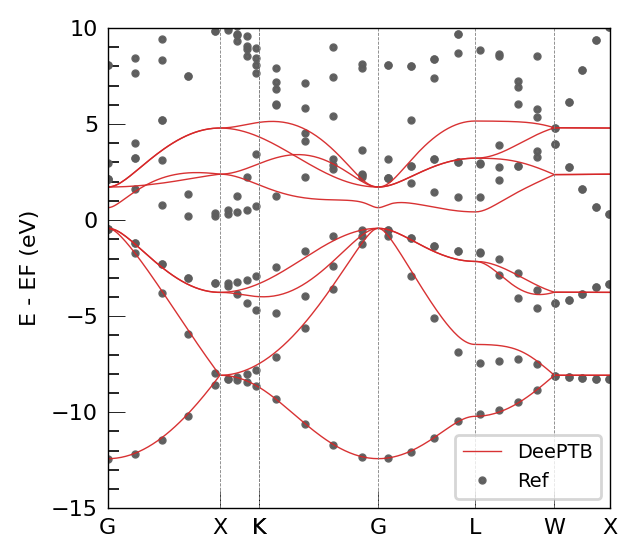

In [2]:
from dptb.postprocess.bandstructure.band import Band
from dptb.nn.build import build_model
from dptb.utils.tools import j_loader

# 为了演示，我们提供了存档文件位于 ref_ckpts/nnsk，也可用于绘图
model = build_model(checkpoint="./ref_ckpts/nnsk/checkpoint/nnsk.iter500.pth")
#model = build_model(checkpoint="./nnsk/checkpoint/nnsk.iter500.pth")

jdata = j_loader("./run/band.json") # 这里提供输入
results_path = "./band_plot"        # 可指定输出的保存路径
kpath_kwargs = jdata["task_options"]
stru_data = "./data/silicon.vasp"
bcal = Band(model=model,
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

我们也可以使用命令行的形式来绘制能带图，这里我们使用DeePTB的后处理功能，dptb run

In [ ]:
! dptb run ./run/band.json -i ./ref_ckpts/nnsk/checkpoint/nnsk.iter500.pth -o band/ -stu ./data/silicon.vasp
#! dptb run ./run/band.json -i ./nnsk/checkpoint/nnsk.iter500.pth -o band/ -stu ./data/silicon.vasp

**小结**: 可以看出该模型已经具有能带的大致形状。要注意的是这里我们只是采用了 3s，3p 轨道，只考虑**第一近邻**。如果我们后续只需要价带的信息，那么**无需增加轨道**，只需要修改训练的能带窗口和调整权重，并可以通过增加近邻的方式得到一个更准确的价带的 TB 模型。

可是往往我们需要导带的信息，这时候我们需要引入更多的轨道，**DeePTB** 支持用户自由地在训练过程中增减轨道和近邻。我们下一步进行增加轨道和近邻的训练。

####  **2.2 增加轨道和近邻**

#####  **2.2.1 增加轨道**

通过修改输入文件，我们在这里加入辅助极化轨道 `d*`，使模型能够拟合考虑的导带。这对于一些需要导带的性质的计算，例如光电性质，和电子的输运性质至关重要。极化轨道的加入可以直接按照下面的写法：
```json
"basis": {
    "Si": ["3s", "3p", "d*"]
    }
```

另外，在进行第一步的时候，我们对于 onsite 的计算没有加修正。我们这里使用 strian 方法，令 `NNSK` 模型能够更新 onsite 矩阵。具体的输入为：

```json
        "nnsk": {
            "onsite": {"method": "strain", "rs":2.5 ,"w":0.3},
            "hopping": {"method": "powerlaw", "rs":2.6, "w": 0.3}
        }
```


这里"method": "strain" 表示开启 strian mode 的 onsite matrix 修正。strain 方法同样需要提供 `rs` 参数，用来表明在 strian 模型下，onsite matrix 只考虑 onsite_cutoff 以内的原子的贡献。对于onsite，通常选取第一近邻即可。

接着，我们通过 `-i[init-model]` 参数加载上一步训练的模型，运行：

In [ ]:
# ~ 25.120 s.
#!dptb train ./inputs/2-2-1_input.json -i ./nnsk/checkpoint/nnsk.iter500.pth -o ./nnsk_2
!dptb train ./inputs/2-2-1_input.json -i ./ref_ckpts/nnsk/checkpoint/nnsk.iter500.pth -o ./nnsk_2



训练收敛后查看能带拟合结果

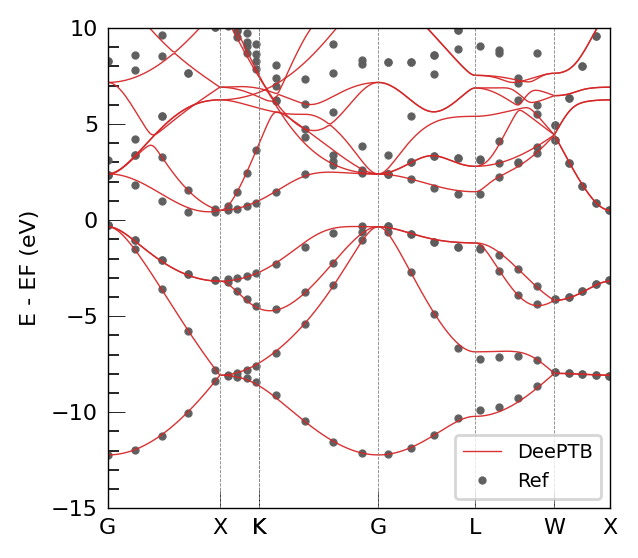

In [59]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_2/checkpoint
model = build_model(checkpoint="./ref_ckpts/nnsk_2/checkpoint/nnsk.ep500.pth")
#model = build_model(checkpoint="./nnsk_2/checkpoint/nnsk.ep500.pth")

jdata = j_loader("./run/band.json") 
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/silicon.vasp"
# AtomicData_options = {"r_max": 2.6, "oer_max": 5.0, "pbc": True}
jdata['task_options']['E_fermi'] = -7.711669921875
bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

In [60]:
! dptb run ./run/band.json -i ./ref_ckpts/nnsk_2/checkpoint/nnsk.ep500.pth -o band/ -stu ./data/silicon.vasp
#! dptb run ./run/band.json -i ./nnsk_2/checkpoint/nnsk.ep500.pth -o band/ -stu ./data/silicon.vasp

 
 
#################################################################################
#                                                                               #
#                                                                               #
#      ██████████                     ███████████  ███████████ ███████████      #
#     ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     #
#      ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     #
#      ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      #
#      ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     #
#      ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     #
#      ██████████  ░░██████ ░░██████  █████           █████    ███████████      #
#     ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       #
#                                                                               #
#           

**Note**: 实际使用中，我们发现用最小基组作为初始训练，并逐渐增加基组的策略，比直接用完整的轨道初始化从头训练更好。这同时可以帮助我们减小使用的基组数，并提升训练的稳定性。

从上面的结果可以看到，此时能带拟合结果已经相当准确。

#####  **2.2.2 增加近邻**

为了进一步提高精度，我可以通过增加近邻键长 `r_max` 来考虑更远的近邻的紧束缚模型。

增加近邻包含两步操作：
1. 在训练的`input.json`的data_options中加入 `r_max`参数，赋值为模型的 $r_{skc} + 8* w$; 即软截断的位置$r_{skc} $ 后 $8* w$ 保证超出 `r_max`的原子不会有影响。对于Si体系，目标$r_{skc} = 5.0$（包含第三近邻，但不包含第四近邻）。
2. 由于原子的离散分布，如果直接突然从最近邻直接加入第二近邻、第三近邻引将引起突变，对哈密顿量的变化太大，会导致之前的拟合结果失效。因此，需要采用一个平滑的阶段函数来对键长的增加进行过渡，通过缓慢地把截断函数向更远的截断推进，从而实现渐进地增加近邻。

截断函数的采取的形式是：
$$f_s(r)=\frac{1}{1+e^{(r-r_{skc})/w}}$$

通过调整参数，我们可以得到一个平滑的过渡。衰减函数在输入文件可设置的参数为：
  - `rs`（Angstrom）：即 $r_{skc}$，控制衰减函数的截断位置；
  - `w`：表示衰减函数的平缓程度。

衰减函数的控制如图所示：

<img src="http://dp-filetrans.oss-accelerate.aliyuncs.com/DeePTB/fs.png?OSSAccessKeyId=LTAI5tRnCpedMnKSH3APDceY&Expires=1001689817842&Signature=vPCZISacus8CuXXsvCWkpU07vQc%3D" alt="Fig2" style="zoom: 40%;">

正如上图所示，这个平滑函数将以 $r_{skc}$ 为中心衰减。这个函数根据 w 的形式，具有不同的平滑性。为了在保持拟合稳定性的同时考虑更多邻居项，我们首先将 $r_{skc}$ 设定为第一最近邻距离，这样的衰减函数可以抑制新包含的第二和第三邻居项，不会对预测的哈密顿带来突然的变化。

我们可以将 $r_{skc}$ 从起始第一近邻慢慢外推到新的 $r_{skc}$ （包含三近邻）。

输入文件中，通过 `push` 关键词中设置 `rs_ths` 和 `period`，即可按照上述公式中的 $r_{skc}$ 从第一近邻缓慢外推至第三近邻。在外推时，每间隔 `period` 个 epoch 就按 `rs_thr` 中设置的每步步长更新 $r_{skc}$。

**注意** 如果 `rs_thr` 设置得太大，那么外推的过程就不能称之为缓变，仍然可能会导致模型训练的不收敛。

具体输入文件可参考 `inputs/2-2-2-1_input.json`。
关键之处，我们需要在输入文件中加入 `push` `r_max`关键词，如下：
```json
    "model_options": {
        "nnsk": {
            ...
            "push": {"rs_thr": 0.024, "period": 15}
        }
    },
    "data_options": {
        "r_max": 7.4,
        "oer_max": 4.9,
        ...
    }
```

In [ ]:
# ~170 s.
!dptb train ./inputs/2-2-2_1_input.json -i ./ref_ckpts/nnsk_2/checkpoint/nnsk.ep500.pth -o ./nnsk_3

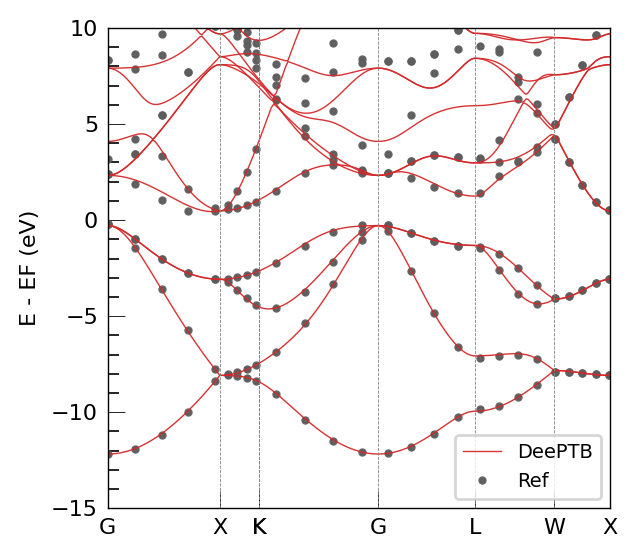

In [61]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_3/checkpoint

model = build_model(checkpoint="./ref_ckpts/nnsk_3/checkpoint/nnsk.iter_rs5.000_w0.300.pth")
#model = build_model(checkpoint="./nnsk_3/checkpoint/nnsk.iter_rs5.000_w0.300.pth")
jdata = j_loader("./run/band.json") # 这里提供输入
results_path = "./band_plot"        # 可指定输出的保存路径
kpath_kwargs = jdata["task_options"]
stru_data = "./data/silicon.vasp"
jdata['task_options']['E_fermi'] = -8.107297897338867

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

In [62]:
! dptb run ./run/band.json -i ./ref_ckpts/nnsk_3/checkpoint/nnsk.iter_rs5.000_w0.300.pth -o band/ -stu ./data/silicon.vasp
#! dptb run ./run/band.json -i ./nnsk_3/checkpoint/nnsk.iter_rs5.000_w0.300.pth -o band/ -stu ./data/silicon.vasp

 
 
#################################################################################
#                                                                               #
#                                                                               #
#      ██████████                     ███████████  ███████████ ███████████      #
#     ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     #
#      ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     #
#      ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      #
#      ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     #
#      ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     #
#      ██████████  ░░██████ ░░██████  █████           █████    ███████████      #
#     ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       #
#                                                                               #
#           

类似地，我们也可以将 $w$ 逐渐变得更小，这样衰减函数引入的衰减将会更快。这一步衰减的目的主要是是在外推 $r_{skc}$ 之后，限制更远的近邻不会进入考虑。
此时修改的输入参数为：
具体输入文件参考 `inputs/2-2-2-2_input.json`。

In [ ]:
# 190 s
ref_ckpts
!dptb train ./inputs/2-2-2_2_input.json -i ./ref_ckpts/nnsk_3/checkpoint/nnsk.iter_rs5.000_w0.300.pth -o ./nnsk_4
#!dptb train ./inputs/2-2-2_2_input.json -i ./nnsk_3/checkpoint/nnsk.iter_rs5.000_w0.300.pth -o ./nnsk_4

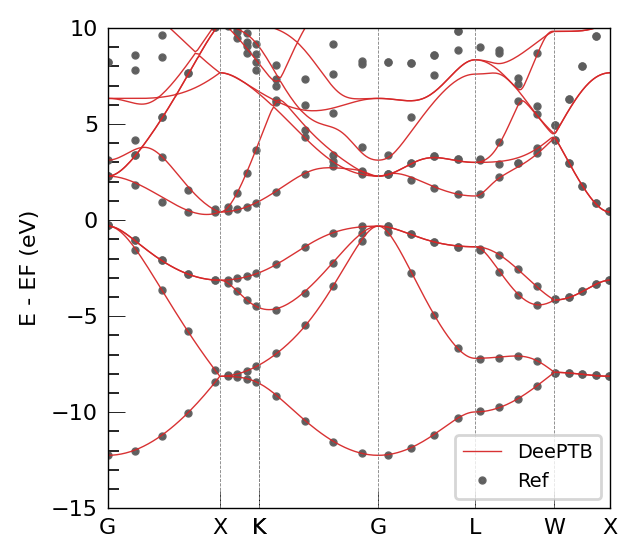

In [63]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_4/checkpoint
model = build_model(checkpoint="./ref_ckpts/nnsk_4/checkpoint/nnsk.iter_rs5.000_w0.100.pth")
#model = build_model(checkpoint="./nnsk_4/checkpoint/nnsk.iter_rs5.000_w0.100.pth")

jdata = j_loader("./run/band.json")
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.8, "oer_max": 4.9}

jdata['task_options']['E_fermi'] = -8.518404006958008

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

In [64]:
! dptb run ./run/band.json -i ./ref_ckpts/nnsk_4/checkpoint/nnsk.iter_rs5.000_w0.100.pth -o band/ -stu ./data/silicon.vasp
#! dptb run ./run/band.json -i ./nnsk_4/checkpoint/nnsk.iter_rs5.000_w0.100.pth -o band/ -stu ./data/silicon.vasp

 
 
#################################################################################
#                                                                               #
#                                                                               #
#      ██████████                     ███████████  ███████████ ███████████      #
#     ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     #
#      ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     #
#      ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      #
#      ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     #
#      ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     #
#      ██████████  ░░██████ ░░██████  █████           █████    ███████████      #
#     ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       #
#                                                                               #
#           

**注意** push 紧邻和w的只会对hopping的参数进行外推，onsite的参数不会进行外推。

####  **2.3 训练MD数据 (键长变化的依赖)**
在 **DeePTB** 中，基于物理图像建模的 SK 积分由各种键长相关函数参数化，例如上面的 `power-law` 形式中键积分就是键长的显函数。这为 `NNSK` 模型提供了良好的转移性，可以充分地模拟结构畸变对电子结构引起的的变化。

为了进一步的提高这样的迁移能力，我们强烈建议进行键长依赖性参数的训练。这样的训练可以通过 MD 轨迹的数据集轻松获得。

我们提供了 25K，100K 和 300K 下的 10 个 MD 帧的数据集。用户可以对应地通过修改输入配置中的 `data_options/train/prefix` 为 `kpathmd25/kpathmd100/kpathmd300`，并在训练时使用 `-i` 初始化检查点训练模型，就可以轻松获得键长依赖的 `NNSK` 模型。
> 这里的能带数据中k点的选取比较密，会降低一定的计算速度。用户可以自行选取部分k点，例如隔3个选取一个点进行训练。

在 MD 轨迹数据集的训练中，输入文件的`data_options`数据输入模块除了提供 MD 轨迹数据的`train`数据集以外，还建议提供先前训练所用的单结构数据集作为`reference`数据集。这样可以使得 MD 轨迹的训练更加稳定。使用`reference`数据集还需要在`train_option`中指定`ref_batch_size`以及在`train_loss`中指定对应的`reference`数据集loss计算方法，其余的输入内容均不变。具体的输入内容可以参考`./inputs/2-3_1_input.json`。

训练得到模型后，用户可以使用上文同样的能带绘制 API 绘制能带结构，绘图相关参数在 `./run/band_2.json` 中。

In [65]:
# ~ 7 mins
!dptb train ./inputs/2-3_1_input.json -i ./ref_ckpts/nnsk_4/checkpoint/nnsk.iter_rs5.000_w0.100.pth -o ./nnsk_md25
#!dptb train ./inputs/2-3_1_input.json -i ./nnsk_4/checkpoint/nnsk.iter_rs5.000_w0.100.pth -o ./nnsk_md25

 
 
#################################################################################
#                                                                               #
#                                                                               #
#      ██████████                     ███████████  ███████████ ███████████      #
#     ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     #
#      ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     #
#      ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      #
#      ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     #
#      ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     #
#      ██████████  ░░██████ ░░██████  █████           █████    ███████████      #
#     ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       #
#                                                                               #
#           

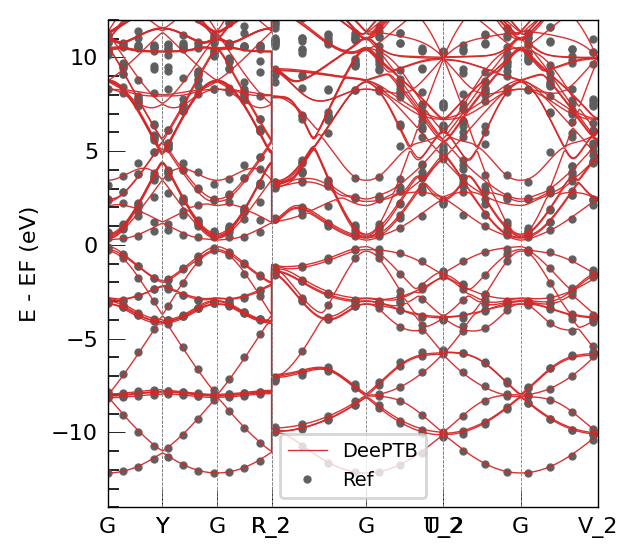

In [3]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_md25/checkpoint
model = build_model(checkpoint="./ref_ckpts/nnsk_md25/checkpoint/nnsk.ep20.pth")
#model = build_model(checkpoint="./nnsk_md25/checkpoint/nnsk.ep20.pth")

jdata = j_loader("./run/band_2.json")
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/kpathmd25.0/struct.vasp"
jdata['task_options']['E_fermi'] = -8.79258918762207

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

In [4]:
! dptb run ./run/band_2.json -i ./ref_ckpts/nnsk_md25/checkpoint/nnsk.ep20.pth -o band/ -stu ./data/kpathmd25.0/struct.vasp
#! dptb run ./run/band_2.json -i ./nnsk_md25/checkpoint/nnsk.ep20.pth -o band/ -stu ./data/kpathmd25.0/struct.vasp

 
 
#################################################################################
#                                                                               #
#                                                                               #
#      ██████████                     ███████████  ███████████ ███████████      #
#     ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     #
#      ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     #
#      ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      #
#      ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     #
#      ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     #
#      ██████████  ░░██████ ░░██████  █████           █████    ███████████      #
#     ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       #
#                                                                               #
#           

在一个温度的MD轨迹下训练得到的模型可以直接加载到另一个温度的MD轨迹下进行进一步的键长变化依赖训练：

In [ ]:
# ~ 8 mins
!dptb train ./inputs/2-3_2_input.json -i ./ref_ckpts/nnsk_md25/checkpoint/nnsk.ep20.pth -o ./nnsk_md100
#!dptb train ./inputs/2-3_2_input.json -i ./nnsk_md25/checkpoint/nnsk.ep20.pth -o ./nnsk_md100

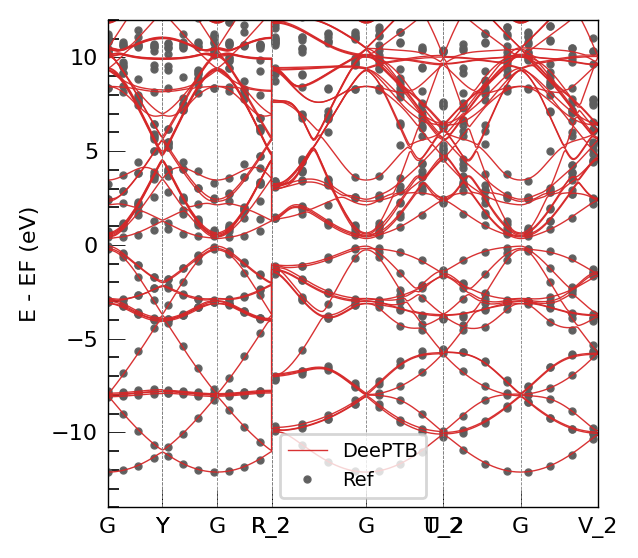

In [5]:
# 演示结果用的存档模型位于 ref_ckpts/nnsk_md100/checkpoint
model = build_model(checkpoint="./ref_ckpts/nnsk_md100/checkpoint/nnsk.ep20.pth")
#model = build_model(checkpoint="./nnsk_md100/checkpoint/nnsk.ep20.pth")

jdata = j_loader("./run/band_2.json")
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/kpathmd25.0/struct.vasp"
jdata['task_options']['E_fermi'] = -8.750761032104492

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

In [6]:
! dptb run ./run/band_2.json -i ./ref_ckpts/nnsk_md100/checkpoint/nnsk.ep20.pth -o band/ -stu ./data/kpathmd25.0/struct.vasp
#! dptb run ./run/band_2.json -i ./nnsk_md100/checkpoint/nnsk.ep20.pth -o band/ -stu ./data/kpathmd25.0/struct.vasp

 
 
#################################################################################
#                                                                               #
#                                                                               #
#      ██████████                     ███████████  ███████████ ███████████      #
#     ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     #
#      ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     #
#      ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      #
#      ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     #
#      ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     #
#      ██████████  ░░██████ ░░██████  █████           █████    ███████████      #
#     ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       #
#                                                                               #
#           

####  **2.4 训练环境修正：dptb 模型**

**DeePTB-SK** 模块提供了具有对称保持神经网络的强大的环境依赖建模。基于前面构建的 `nnsk` 模型，我们可以通过加入环境依赖的部分进一步增强TB模型的描述能力，以克服由两中心近似带来的精度限制。在 `nnsk` 模型基础上，加入环境依赖性的模型称为`mix`模型，其能量表达式如下：
$$
\begin{equation}
h^{\text{env}}_{ll^\prime{\zeta}} =  h_{ll^\prime{\zeta}}(r_{ij}) \times \left[1+\Phi_{ll^\prime\zeta}^{o_i,o_j}\left(r_{ij},\mathcal{D}^{ij}\right)\right]	
\end{equation}
$$
其中，$\mathcal{D}^{ij}$ 是环境描述符，通过 `embedding` 关键词定义；而 $\Phi_{ll^\prime\zeta}^{o_i,o_j}$ 则是提供环境修正预测值的神经网络。

定义`dptb`模型，需要在训练输入文件的`model_options`提供下面的关键词：
- `embedding`：其中的`method`指定在`dptb`模型中使用的原子环境的描述符形式，在本例中我们使用类似 **DeePMD** 中使用的 `se2` 形式描述符，描述符形式可以参见[DeePTB paper](https://arxiv.org/abs/2307.04638)；
- `prediction`：用`method`指定模型的预测方法，这里指定为`sktb`，其中`neurons`指定了预测网络的大小；
- `nnsk`：与`nnsk`模型中的内容一致。其中，`freeze`选项应设置为`true`，表示固定`nnsk`模型训练好的sk参数，只训练环境依赖部分的神经网络参数。这部分的固定很重要，否则在`dptb`第一步初始化就有可能完全破坏`nnsk`的参数，导致训练不收敛。
```json
    "model_options": {
        "embedding":{
            "method": "se2",
            "rs": 2.5,
            "rc": 5.0,
            "radial_net": {
                "neurons": [10,20,30]
            }
        },
        "prediction":{
            "method": "sktb",
            "neurons": [16,16,16]
        },
        "nnsk": {
            "onsite": {"method": "strain", "rs":2.5 ,"w":0.3},
            "hopping": {"method": "powerlaw", "rs":5.0, "w": 0.1},
            "freeze": true
        }
    }
```
输入的完整内容可以参看`./inputs/2-4_input.json`。环境依赖的`mix`模型训练需要读取`nnsk`的模型。我们可以运行：

In [ ]:
# ~ 8 mins 
!dptb train ./inputs/2-4_input.json -i ./ref_ckpts/nnsk_md100/checkpoint/nnsk.ep20.pth -o ./mix
#!dptb train ./inputs/2-4_input.json -i ./nnsk_md100/checkpoint/nnsk.ep20.pth -o ./mix

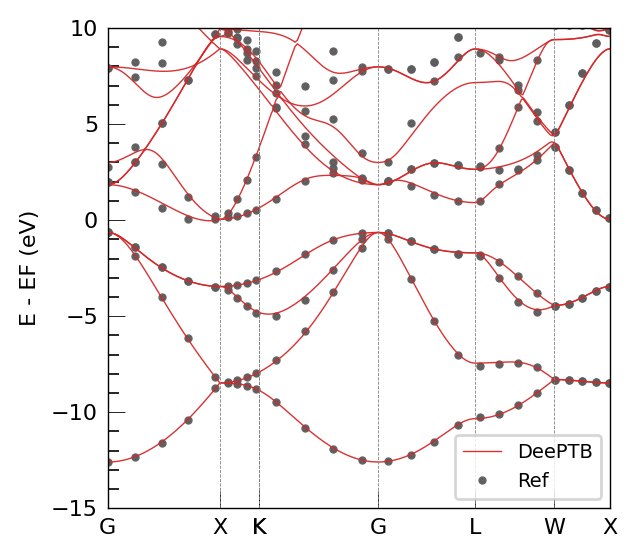

In [8]:
# 绘制dptb拟合的能带需要加载 MIX 模型
from dptb.nn.deeptb import MIX

# 演示结果用的存档模型位于 ref_ckpts/mix/checkpoint
model = build_model(checkpoint="./ref_ckpts/mix/checkpoint/mix.iter200.pth")
#model = build_model(checkpoint="./mix/checkpoint/mix.iter200.pth")

jdata_run = j_loader("./run/band.json")
results_path = "./band_plot"
kpath_kwargs = jdata_run["task_options"]
stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "er_max":5.0, "oer_max": 2.5, "pbc": True}

jdata_run['task_options']['E_fermi'] =-8.285916328430176

bcal = Band(model=model, 
            use_gui=True, 
            results_path=results_path, 
            device=model.device)
bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

In [9]:
!dptb run ./run/band.json -i ./ref_ckpts/mix/checkpoint/mix.iter200.pth  -o band/ -stu ./data/silicon.vasp
#!dptb run ./run/band.json -i ./mix/checkpoint/mix.iter200.pth  -o band/ -stu ./data/silicon.vasp

 
 
#################################################################################
#                                                                               #
#                                                                               #
#      ██████████                     ███████████  ███████████ ███████████      #
#     ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     #
#      ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     #
#      ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      #
#      ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     #
#      ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     #
#      ██████████  ░░██████ ░░██████  █████           █████    ███████████      #
#     ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       #
#                                                                               #
#           